In [1]:
import matlab.engine

In [2]:
from shutil import copyfile

In [3]:
import numpy as np
import pandas as pd

In [4]:
import matplotlib.pyplot as plt

In [5]:
eng = matlab.engine.start_matlab()

In [6]:
eng.load_system("../Simulink/polydome", background = True)

Which experimental set to simulate:

In [7]:
exp_id = 'Exp1'

Copy the corresponding WDB to the model input location:

In [8]:
copyfile(f"../Data/Experimental_data_WDB/{exp_id}_WDB.mat", "../Data/input_WDB.mat")

'../Data/input_WDB.mat'

In [9]:
df_wdb = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_WDB.pkl")
df_wdb.head()

,time,timestamp,zenith,azimuth,dni,dhi,OutsideTemp,Tsky_rad,relative_humidity,precipitation,cloud_index,pressure,wind_speed,wind_direction,aoi,incidence_main,incidence_second,poa_direct,poa_diffuse
0,0,201706012000,78.691622,290.430819,7.251337,59.908644,22.0,16.0,50,-9999,0.5,96300,0,-9999,78.691622,-9999,-9999,1.421911,59.908644
1,300,201706012005,79.489651,291.279501,7.672114,56.537088,22.0,16.0,50,-9999,0.5,96300,0,-9999,79.489651,-9999,-9999,1.399494,56.537088
2,600,201706012010,80.282334,292.130503,8.423139,53.492674,22.0,16.0,50,-9999,0.5,96300,0,-9999,80.282334,-9999,-9999,1.421769,53.492674
3,900,201706012015,81.069332,292.984123,52.657244,65.770239,22.0,16.0,50,-9999,0.5,96300,0,-9999,81.069332,-9999,-9999,8.174467,65.770239
4,1200,201706012020,81.850261,293.840653,94.364403,62.829177,22.0,16.0,50,-9999,0.5,96300,0,-9999,81.850261,-9999,-9999,13.377157,62.829177


In [10]:
df = pd.read_pickle(f"../Data/Experimental_python/{exp_id}_data.pkl")
df.head()

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad
timestamp,,,,,,
2017-06-01 20:00:00+02:00,4325.034483,23.5,22.0,24.5,24.300000,61.321333
2017-06-01 20:05:00+02:00,4287.000000,23.5,22.0,15.5,24.283333,57.926100
2017-06-01 20:10:00+02:00,4319.766667,23.5,22.0,15.2,24.083333,54.902033
2017-06-01 20:15:00+02:00,2893.344828,23.5,22.0,14.9,23.933333,73.860700
2017-06-01 20:20:00+02:00,59.137931,23.5,22.0,18.2,23.666667,76.042533


In [11]:
runtime = df_wdb['time'].iloc[-1]
print(f"Experiment runtime: {runtime}")

Experiment runtime: 161700


### Simulink

Set the CARNOT simulation initial temperature `t0`

In [12]:
eng.workspace['t0'] = float(df['InsideTemp'][0])

Set the CARNOT simulation air exchange rate

In [13]:
day_air_exchange_rate = 0.0
night_air_exchange_rate = 0.0

In [14]:
air_exchange_rate = np.zeros((df_wdb.shape[0], 2))
air_exchange_rate[:, 0] = df_wdb['time']
air_exchange_rate[:, 1] = np.where(df['Power'] < 100, day_air_exchange_rate, night_air_exchange_rate)
eng.workspace['air_exchange_rate'] = matlab.double(air_exchange_rate.tolist())

Set the CARNOT simulation input heat power

Get the original electric power consumption

In [15]:
power = np.array([df_wdb['time'], df['Power']]).T

Get the heating power by passing through a heating/cooling COP

In [16]:
COP_heating = -5.0
COP_cooling = 5.0

In [17]:
COP = np.where(df['Setpoint'] > df['InsideTemp'], COP_heating, -1*COP_cooling)

In [18]:
power[:, 1] = COP * power[:, 1]

In [19]:
eng.workspace['power'] = matlab.double(power.tolist())

In [20]:
eng.set_param('polydome', 'StopTime', str(runtime), nargout = 0)

In [21]:
eng.workspace['result'] = eng.sim('polydome')

Interpret the resulting data as a python dataframe

In [22]:
dict_simulation = {}
dict_simulation['values'] = np.asarray(eng.eval('result.SimulatedTemp.Data')).reshape(-1)
dict_simulation['time'] = np.asarray(eng.eval('result.SimulatedTemp.Time')).reshape(-1)

In [23]:
df_simulation = pd.DataFrame(dict_simulation)
#df_simulation['time'] = df_simulation['time'].astype(int)
df_simulation.set_index('time', inplace = True, drop = True)

In [24]:
df_simulation['timestamp'] = df.index[0] + df_simulation.index.map(lambda x: pd.Timedelta(seconds = x))

In [25]:
df_simulation = df_simulation.reset_index().set_index('timestamp')

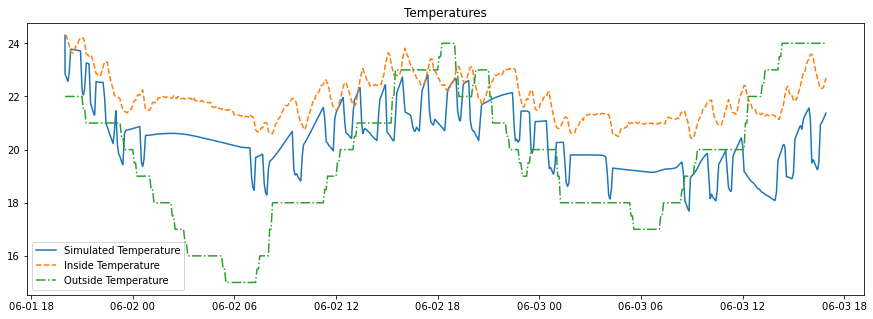

In [26]:
plt.figure(figsize = (15, 5))
plt.plot(df_simulation.index, df_simulation['values'], label = 'Simulated Temperature')
plt.plot(df.index, df['InsideTemp'], '--',label = 'Inside Temperature')
plt.plot(df.index, df['OutsideTemp'], '-.', label = 'Outside Temperature')
plt.title('Temperatures')
plt.legend()
plt.show()

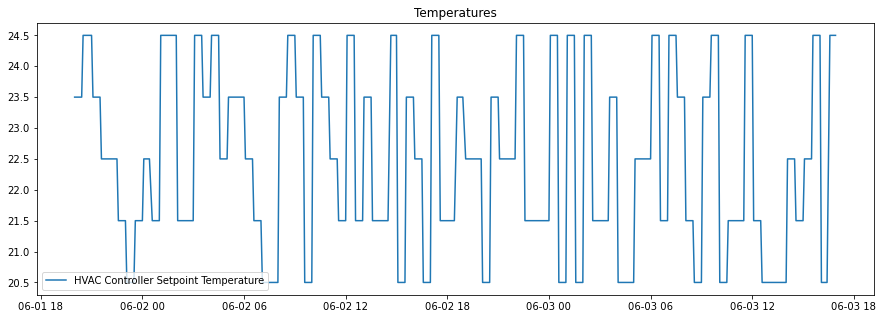

In [27]:
plt.figure(figsize = (15, 5))
plt.plot(df.index, df['Setpoint'], label = 'HVAC Controller Setpoint Temperature')
plt.title('Temperatures')
plt.legend()
plt.show()

In [28]:
# Resample to 5/10/15 min by taking the mean when there are multiple points, and padding with zero order when data is missing

In [29]:
df_resampled_5 = df_simulation['values'].resample('5min').mean().pad()
df_resampled_10 = df_simulation['values'].resample('10min').mean().pad()
df_resampled_15 = df_simulation['values'].resample('15min').mean().pad()

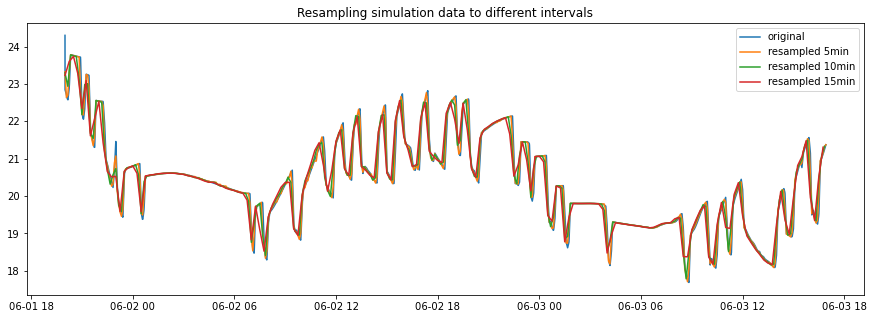

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(df_simulation.index, df_simulation['values'], label = 'original')
plt.plot(df_resampled_5.index, df_resampled_5, label = 'resampled 5min')
plt.plot(df_resampled_10.index, df_resampled_10, label = 'resampled 10min')
plt.plot(df_resampled_15.index, df_resampled_15, label = 'resampled 15min')
plt.title('Resampling simulation data to different intervals')
plt.legend()
plt.show()

Export the resampled data-set for further use

In [31]:
df_resampled_5.to_pickle(f"../Data/CARNOT_output/{exp_id}_simulation_df.pkl")

<AxesSubplot:xlabel='timestamp'>

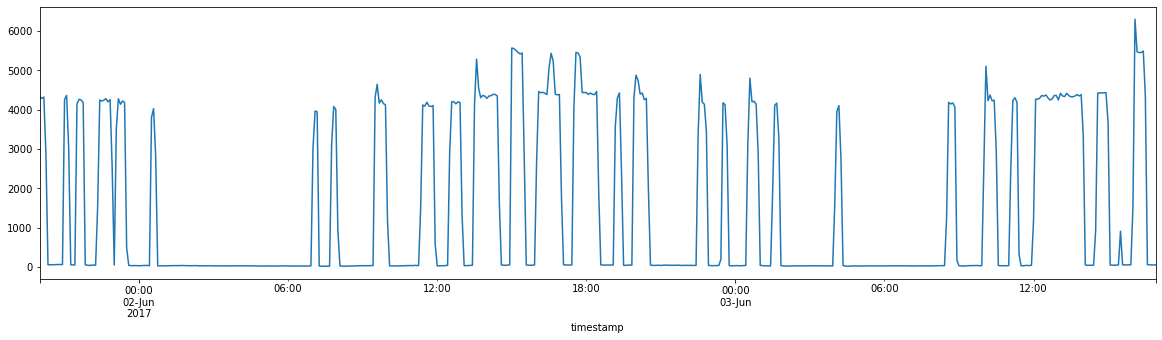

In [32]:
df['Power'].plot(figsize = (20, 5))

Add the outputs to the experimental df and export the result: 

In [33]:
df['Heat'] = power[:, 1]
df['SimulatedTemp'] = df_resampled_5

In [34]:
df

,Power,Setpoint,OutsideTemp,SupplyTemp,InsideTemp,SolRad,Heat,SimulatedTemp
timestamp,,,,,,,,
2017-06-01 20:00:00+02:00,4325.034483,23.5,22.0,24.5,24.300000,61.321333,-21625.172414,23.324679
2017-06-01 20:05:00+02:00,4287.000000,23.5,22.0,15.5,24.283333,57.926100,-21435.000000,22.632962
2017-06-01 20:10:00+02:00,4319.766667,23.5,22.0,15.2,24.083333,54.902033,-21598.833333,22.696056
2017-06-01 20:15:00+02:00,2893.344828,23.5,22.0,14.9,23.933333,73.860700,-14466.724138,23.299014
2017-06-01 20:20:00+02:00,59.137931,23.5,22.0,18.2,23.666667,76.042533,-295.689655,23.778789
...,...,...,...,...,...,...,...,...
2017-06-03 16:35:00+02:00,62.137931,24.5,24.0,16.4,22.300000,361.247267,-310.689655,20.947152
2017-06-03 16:40:00+02:00,57.482759,24.5,24.0,17.6,22.300000,596.456167,-287.413793,21.039538
2017-06-03 16:45:00+02:00,56.233333,24.5,24.0,18.5,22.316667,550.335400,-281.166667,21.153586


Quick sanity check 

NOTE: This assumption is only correct for for experiments 1 and 2, but is currently applied everywhere.
Keeping track of this only ensures that the GP can train on the same data that is fed to CARNOT

In [35]:
(np.where(np.sign(df['Setpoint'] - df['InsideTemp']) == 1, 1, -3) * df['Power']).equals(df['Heat'])

False

In [36]:
df.to_pickle(f"../Data/CARNOT_output/{exp_id}_full.pkl")

<AxesSubplot:xlabel='timestamp'>

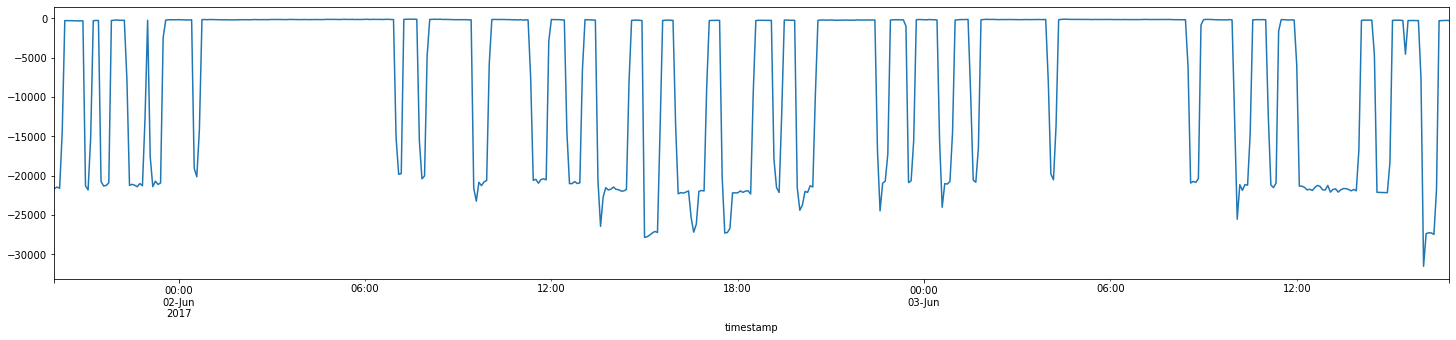

In [37]:
df['Heat'].plot(figsize = (25, 5))